In [15]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision for MNIST
import torchvision
import torchvision.transforms as transforms

# Visualization and array operations
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [16]:
# Define transforms (normalize to [0,1] range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


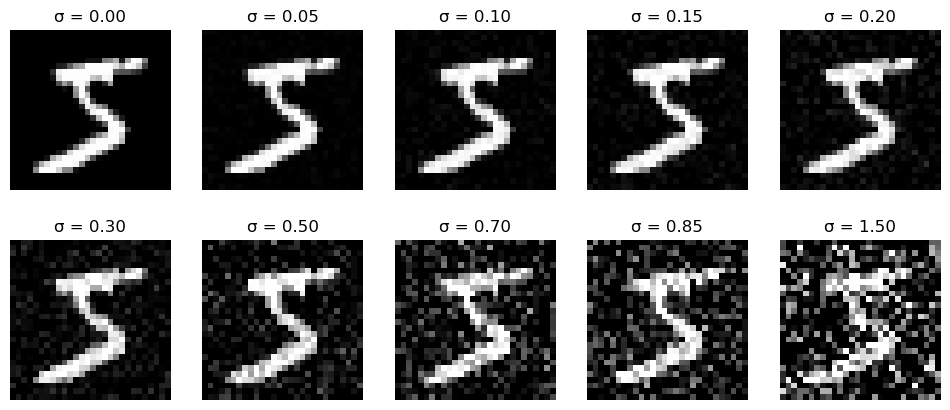


Dataset structure:
Image tensor shape: torch.Size([1, 28, 28])
Label type: <class 'int'>
Normalized pixel value range: [-0.42, 2.82]

Noise levels visualized: [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.85, 1.5]


In [17]:
# Define noise levels to visualize
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.85, 1.5]

# Get one sample
img_idx = 0  # Change this to see different digits
img, label = train_dataset[img_idx]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    noise_std = noise_levels[i]

    # Add noise to the normalized image
    noisy_img = img.clone()
    if noise_std > 0:
        noise = torch.randn_like(noisy_img) * noise_std
        noisy_img = noisy_img + noise

    # Denormalize and convert to numpy
    img_display = noisy_img.squeeze().numpy() * 0.3081 + 0.1307

    # Clip to valid range for display
    img_display = np.clip(img_display, 0, 1)

    ax.imshow(img_display, cmap='gray')
    ax.set_title(f'σ = {noise_std:.2f}')
    ax.axis('off')

plt.show()

# Check structure
print(f"\nDataset structure:")
print(f"Image tensor shape: {train_dataset[0][0].shape}")
print(f"Label type: {type(train_dataset[0][1])}")
print(f"Normalized pixel value range: [{train_dataset[0][0].min():.2f}, {train_dataset[0][0].max():.2f}]")
print(f"\nNoise levels visualized: {noise_levels}")

In [18]:
class SimpleCNN_BiasFree(nn.Module):
    def __init__(self):
        super(SimpleCNN_BiasFree, self).__init__()
        # Convolutional layers WITHOUT bias
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)

        # Fully connected layers WITHOUT bias
        self.fc1 = nn.Linear(32 * 7 * 7, 128, bias=False)
        self.fc2 = nn.Linear(128, 10, bias=False)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleCNN_BiasFree().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleCNN_BiasFree(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=10, bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Total parameters: 206,736


In [19]:
def train_epoch(model, train_loader, optimizer, criterion, device, noise_std=0.0):
    """Train for one epoch with optional Gaussian noise injection"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Add Gaussian noise to inputs if specified
        if noise_std > 0:
            noise = torch.randn_like(images) * noise_std
            images = images + noise

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    """Evaluate on test set"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Initialize model, loss, optimizer
model = SimpleCNN_BiasFree().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized. Ready to train.")

Model initialized. Ready to train.


In [20]:
# Training parameters
num_epochs = 1
noise_std = 0.01  # Set to 0.1 or 0.2 to add noise during training

# Training history
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Training for {num_epochs} epochs with noise_std={noise_std}")
print("-" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, noise_std=noise_std
    )

    # Test
    test_loss, test_acc = test(model, test_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

print("-" * 60)
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")

"""  # Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(test_accs, label='Test Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True) """

Training for 1 epochs with noise_std=0.01
------------------------------------------------------------
Epoch  1/1 | Train Loss: 0.1990 | Train Acc: 94.03% | Test Loss: 0.0563 | Test Acc: 98.25%
------------------------------------------------------------
Final Test Accuracy: 98.25%


"  # Plot training curves\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))\n\nax1.plot(train_losses, label='Train Loss')\nax1.plot(test_losses, label='Test Loss')\nax1.set_xlabel('Epoch')\nax1.set_ylabel('Loss')\nax1.set_title('Loss Curves')\nax1.legend()\nax1.grid(True)\n\nax2.plot(train_accs, label='Train Acc')\nax2.plot(test_accs, label='Test Acc')\nax2.set_xlabel('Epoch')\nax2.set_ylabel('Accuracy (%)')\nax2.set_title('Accuracy Curves')\nax2.legend()\nax2.grid(True) "

Computing Jacobians and contributions for 5 test images...


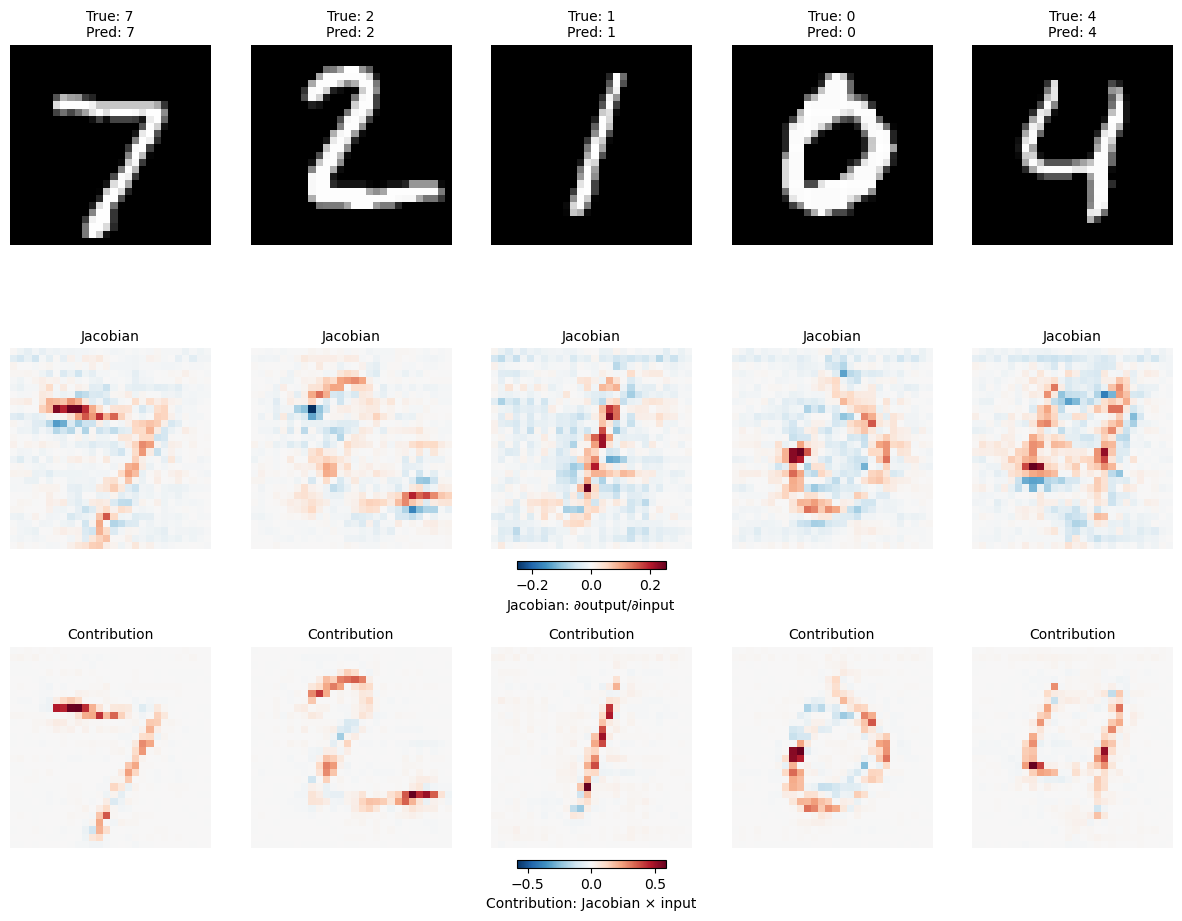


Interpretation:
- Row 1: Original digit images
- Row 2: Jacobian (∂output/∂input) - sensitivity of output to each pixel
- Row 3: Contribution (Jacobian × input) - actual pixel contribution to output

For bias-free networks: sum of all contributions ≈ output logit
Blue = positive contribution, Red = negative contribution


In [21]:
def compute_jacobian_for_predicted_class(model, image):
    """
    Compute Jacobian of predicted class output w.r.t. input image

    Returns:
        jacobian: shape (28, 28) - gradient of predicted class logit w.r.t. each pixel
        predicted_class: the predicted digit
        logits: the output logits
    """
    image.requires_grad = True

    # Forward pass
    output = model(image.unsqueeze(0))  # Add batch dimension
    predicted_class = output.argmax(dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    jacobian = image.grad.squeeze().cpu().numpy()  # Shape: (1, 28, 28) -> (28, 28)

    return jacobian, predicted_class, output.detach().cpu().numpy()

def visualize_jacobians_with_contribution(model, test_dataset, n=5, device='cpu'):
    """
    Visualize original images, Jacobians, and actual pixel contributions

    For bias-free networks: output = Jacobian @ input
    So: pixel_contribution = jacobian * input (elementwise)
    """
    model.eval()

    fig, axes = plt.subplots(3, n, figsize=(3*n, 11))

    for i in range(n):
        # Get test sample
        image, true_label = test_dataset[i]
        image = image.to(device)

        # Compute Jacobian
        with torch.enable_grad():
            jacobian, pred_class, logits = compute_jacobian_for_predicted_class(model, image)

        # Get normalized input image
        img_normalized = image.detach().squeeze().cpu().numpy()  # Still normalized

        # Compute actual contribution: jacobian * input (elementwise)
        contribution = jacobian * img_normalized

        # Denormalize image for display
        img_display = img_normalized * 0.3081 + 0.1307

        # Row 1: original images
        axes[0, i].imshow(img_display, cmap='gray')
        axes[0, i].set_title(f'True: {true_label}\nPred: {pred_class}', fontsize=10)
        axes[0, i].axis('off')

        # Row 2: Jacobian (sensitivity)
        vmax_jac = np.abs(jacobian).max()
        axes[1, i].imshow(jacobian, cmap='RdBu_r', vmin=-vmax_jac, vmax=vmax_jac)
        axes[1, i].set_title(f'Jacobian', fontsize=10)
        axes[1, i].axis('off')

        # Row 3: Contribution (jacobian * input)
        vmax_contrib = np.abs(contribution).max()
        im = axes[2, i].imshow(contribution, cmap='RdBu_r', vmin=-vmax_contrib, vmax=vmax_contrib)
        axes[2, i].set_title(f'Contribution', fontsize=10)
        axes[2, i].axis('off')

    # Add colorbars
    fig.colorbar(axes[1, 0].images[0], ax=axes[1, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Jacobian: ∂output/∂input')
    fig.colorbar(im, ax=axes[2, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Contribution: Jacobian × input')

    plt.show()

# Run visualization
n_samples = 5
print(f"Computing Jacobians and contributions for {n_samples} test images...")
visualize_jacobians_with_contribution(model, test_dataset, n=n_samples, device=device)
print("\nInterpretation:")
print("- Row 1: Original digit images")
print("- Row 2: Jacobian (∂output/∂input) - sensitivity of output to each pixel")
print("- Row 3: Contribution (Jacobian × input) - actual pixel contribution to output")
print("\nFor bias-free networks: sum of all contributions ≈ output logit")
print("Blue = positive contribution, Red = negative contribution")

Computing Jacobians for 2500 samples...
  Processed 1000/2500
  Processed 2000/2500
Jacobian matrix shape: (2500, 784)

PCA explained variance: [0.06098697 0.05052822]
Total variance explained: 0.112


/home/ubuntu/miniconda3/envs/gpmap/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


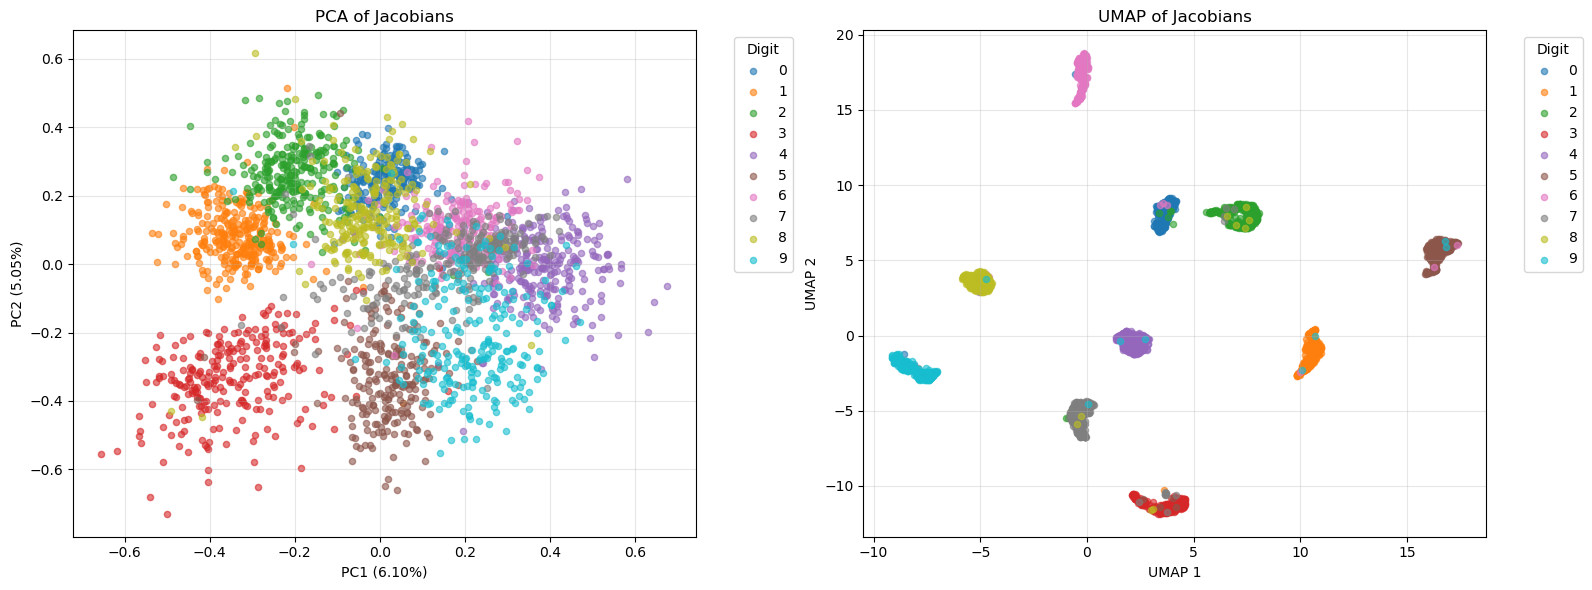

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Note: you'll need to install umap-learn: pip install umap-learn
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available. Install with: pip install umap-learn")

def harvest_jacobians(model, test_dataset, n_samples=500, device='cpu'):
    """
    Compute Jacobians for n_samples test images

    Returns:
        jacobians: (n_samples, 784) flattened Jacobian matrices
        labels: (n_samples,) true labels
        predictions: (n_samples,) predicted labels
    """
    model.eval()

    jacobians = []
    labels = []
    predictions = []

    print(f"Computing Jacobians for {n_samples} samples...")
    for i in range(n_samples):
        image, label = test_dataset[i]
        image = image.to(device)

        with torch.enable_grad():
            jacobian, pred_class, _ = compute_jacobian_for_predicted_class(model, image)

        jacobians.append(jacobian.flatten())  # 28x28 -> 784
        labels.append(label)
        predictions.append(pred_class)

        if (i + 1) % 1000 == 0:
            print(f"  Processed {i+1}/{n_samples}")

    jacobians = np.array(jacobians)  # Shape: (n_samples, 784)
    labels = np.array(labels)
    predictions = np.array(predictions)

    print(f"Jacobian matrix shape: {jacobians.shape}")
    return jacobians, labels, predictions

def visualize_jacobian_embedding(jacobians, labels, method='pca'):
    """
    Visualize Jacobians in 2D using PCA or UMAP, colored by digit

    Args:
        jacobians: (n_samples, 784) Jacobian vectors
        labels: (n_samples,) digit labels
        method: 'pca', 'umap', or 'both'
    """
    n_components = 2

    if method in ['pca', 'both']:
        # Apply PCA
        pca = PCA(n_components=n_components)
        embedding_pca = pca.fit_transform(jacobians)

        print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    if method in ['umap', 'both']:
        if not HAS_UMAP:
            print("UMAP not available, skipping...")
        else:
            # Apply UMAP
            reducer = umap.UMAP(n_components=n_components, random_state=42)
            embedding_umap = reducer.fit_transform(jacobians)

    # Plotting
    if method == 'both':
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        axes = [axes]

    # Color map for digits
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Plot PCA
    if method in ['pca', 'both']:
        ax = axes[0] if method == 'both' else axes[0]
        for digit in range(10):
            mask = labels == digit
            ax.scatter(embedding_pca[mask, 0], embedding_pca[mask, 1],
                      c=[colors[digit]], label=str(digit), alpha=0.6, s=20)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax.set_title('PCA of Jacobians')
        ax.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    # Plot UMAP
    if method in ['umap', 'both'] and HAS_UMAP:
        ax = axes[1] if method == 'both' else axes[0]
        for digit in range(10):
            mask = labels == digit
            ax.scatter(embedding_umap[mask, 0], embedding_umap[mask, 1],
                      c=[colors[digit]], label=str(digit), alpha=0.6, s=20)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title('UMAP of Jacobians')
        ax.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the analysis
n_samples = 2500  # Use more for better UMAP
jacobians, labels, predictions = harvest_jacobians(model, test_dataset, n_samples=n_samples, device=device)

# Visualize with both PCA and UMAP
visualize_jacobian_embedding(jacobians, labels, method='both')

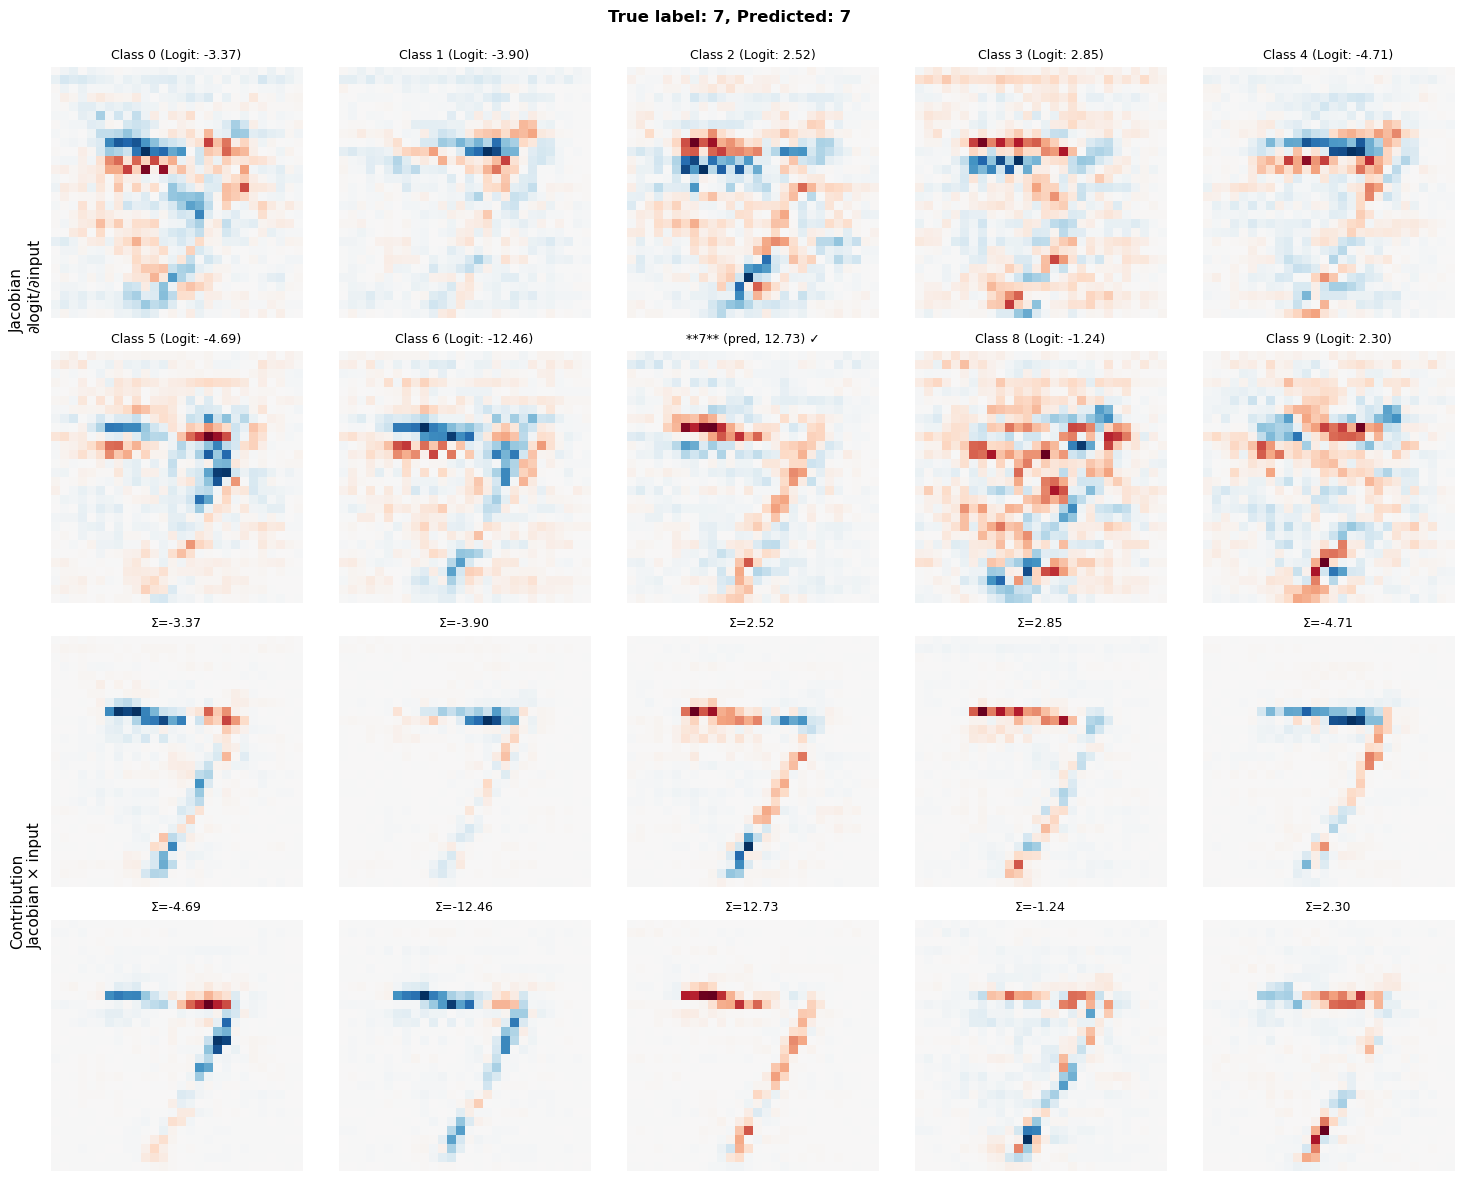

Logit values vs sum of contributions:
  Class 0: logit=-3.3717, Σ(contrib)=-3.3717, diff=4.77e-07
  Class 1: logit=-3.9037, Σ(contrib)=-3.9037, diff=2.38e-07
  Class 2: logit= 2.5230, Σ(contrib)= 2.5230, diff=0.00e+00
  Class 3: logit= 2.8535, Σ(contrib)= 2.8535, diff=2.38e-07
  Class 4: logit=-4.7110, Σ(contrib)=-4.7110, diff=9.54e-07
  Class 5: logit=-4.6870, Σ(contrib)=-4.6870, diff=4.77e-07
  Class 6: logit=-12.4584, Σ(contrib)=-12.4584, diff=9.54e-07
  Class 7: logit=12.7300, Σ(contrib)=12.7300, diff=9.54e-07
  Class 8: logit=-1.2410, Σ(contrib)=-1.2410, diff=1.19e-07
  Class 9: logit= 2.3003, Σ(contrib)= 2.3003, diff=2.38e-07


In [23]:
def compute_all_class_jacobians(model, image):
    """Compute Jacobian for each of the 10 output classes"""
    jacobians = []

    for target_class in range(10):
        image_copy = image.clone().detach()
        image_copy.requires_grad = True

        output = model(image_copy.unsqueeze(0))
        model.zero_grad()
        output[0, target_class].backward()

        jac = image_copy.grad.squeeze().cpu().numpy()
        jacobians.append(jac)

    return np.array(jacobians)  # Shape: (10, 28, 28)
def visualize_all_class_jacobians(model, test_dataset, idx=0, device='cpu'):
    """Visualize Jacobians and contributions for all 10 classes"""
    model.eval()

    image, true_label = test_dataset[idx]
    image = image.to(device)

    # Get prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        predicted_class = output.argmax(dim=1).item()
        logits = output[0].cpu().numpy()

    # Get normalized input
    img_normalized = image.detach().squeeze().cpu().numpy()

    # Compute Jacobians for all classes
    jacobians = compute_all_class_jacobians(model, image)

    # Compute contributions for all classes
    contributions = jacobians * img_normalized[np.newaxis, :, :]  # Broadcasting

    # Visualize: 4 rows (2 for jacobians, 2 for contributions) × 5 cols
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for class_idx in range(10):
        col = class_idx % 5

        # Row for jacobian
        ax_jac = axes[class_idx // 5, col]

        # Row for contribution (offset by 2 rows)
        ax_contrib = axes[2 + class_idx // 5, col]

        # Plot Jacobian
        jac = jacobians[class_idx]
        vmax_jac = np.abs(jac).max()
        ax_jac.imshow(jac, cmap='RdBu_r', vmin=-vmax_jac, vmax=vmax_jac)

        title = f'Class {class_idx} (Logit: {logits[class_idx]:.2f})'
        if class_idx == predicted_class:
            title = f'**{class_idx}** (pred, {logits[class_idx]:.2f})'
        if class_idx == true_label:
            title += ' ✓'

        ax_jac.set_title(title, fontsize=9)
        ax_jac.axis('off')

        # Plot Contribution
        contrib = contributions[class_idx]
        vmax_contrib = np.abs(contrib).max()
        ax_contrib.imshow(contrib, cmap='RdBu_r', vmin=-vmax_contrib, vmax=vmax_contrib)

        # Verify sum for bias-free network
        sum_contrib = np.sum(contrib)
        ax_contrib.set_title(f'Σ={sum_contrib:.2f}', fontsize=9)
        ax_contrib.axis('off')

    # Add row labels
    fig.text(0.02, 0.75, 'Jacobian\n∂logit/∂input', va='center', rotation='vertical', fontsize=11)
    fig.text(0.02, 0.25, 'Contribution\nJacobian × input', va='center', rotation='vertical', fontsize=11)

    # Display original image
    img_display = img_normalized * 0.3081 + 0.1307
    fig.text(0.5, 0.97, f'True label: {true_label}, Predicted: {predicted_class}',
             ha='center', fontsize=12, weight='bold')

    plt.tight_layout(rect=[0.03, 0, 1, 0.96])
    plt.show()

    # Print verification
    print("Logit values vs sum of contributions:")
    for class_idx in range(10):
        sum_contrib = np.sum(contributions[class_idx])
        diff = abs(logits[class_idx] - sum_contrib)
        print(f"  Class {class_idx}: logit={logits[class_idx]:7.4f}, "
              f"Σ(contrib)={sum_contrib:7.4f}, diff={diff:.2e}")

# Run it
visualize_all_class_jacobians(model, test_dataset, idx=0, device=device)

Computing Jacobians and contributions for 100 samples per class...
  Processed 200 samples, collected: [17, 28, 16, 16, 28, 20, 20, 24, 10, 21]
  Processed 400 samples, collected: [33, 57, 43, 35, 46, 41, 34, 41, 27, 41]
  Processed 600 samples, collected: [52, 73, 63, 61, 66, 55, 51, 57, 50, 64]
  Processed 800 samples, collected: [68, 99, 85, 80, 90, 72, 67, 77, 67, 80]
  Processed 1000 samples, collected: [83, 100, 100, 100, 100, 84, 86, 96, 84, 94]
Class 0: 100 samples
Class 1: 100 samples
Class 2: 100 samples
Class 3: 100 samples
Class 4: 100 samples
Class 5: 100 samples
Class 6: 100 samples
Class 7: 100 samples
Class 8: 100 samples
Class 9: 100 samples


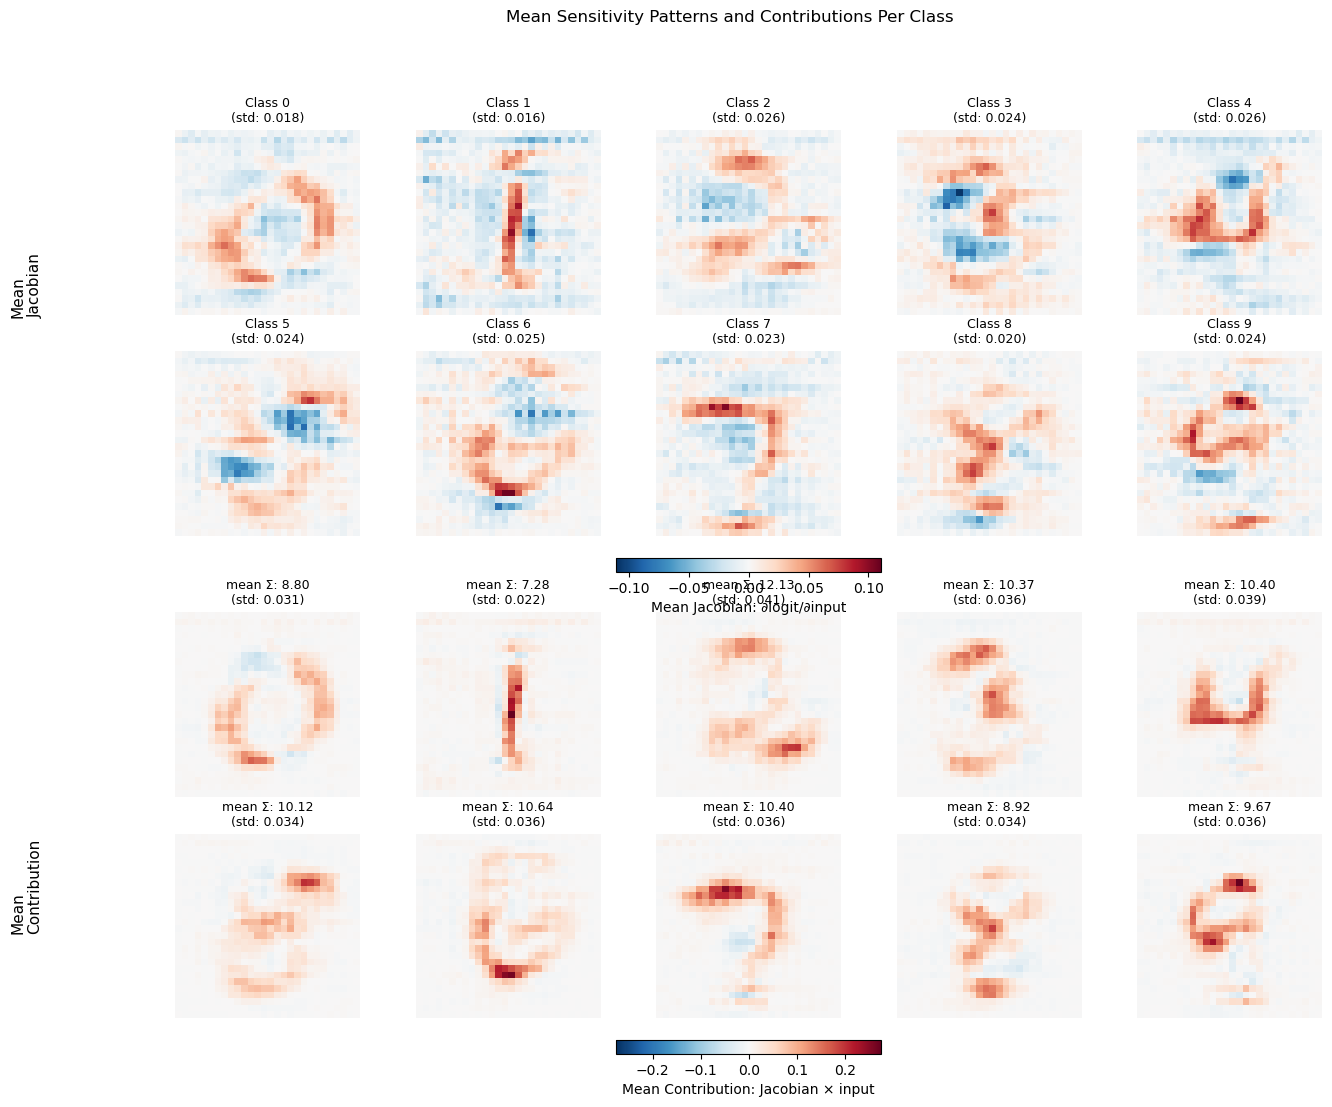

In [24]:
def compute_mean_jacobians_and_contributions_per_class(model, test_dataset, n_samples_per_class=100, device='cpu'):
    """
    Compute mean Jacobian and mean contributions for each digit class

    Returns:
        mean_jacobians: (10, 28, 28) - average Jacobian for each class
        std_jacobians: (10, 28, 28) - standard deviation of Jacobians
        mean_contributions: (10, 28, 28) - average contribution (Jacobian × input)
        std_contributions: (10, 28, 28) - standard deviation of contributions
    """
    model.eval()

    # Collect Jacobians and contributions organized by true label
    jacobians_by_class = {i: [] for i in range(10)}
    contributions_by_class = {i: [] for i in range(10)}

    print(f"Computing Jacobians and contributions for {n_samples_per_class} samples per class...")

    for idx in range(len(test_dataset)):
        image, true_label = test_dataset[idx]

        # Stop if we have enough for this class
        if len(jacobians_by_class[true_label]) >= n_samples_per_class:
            # Check if all classes are complete
            if all(len(jacs) >= n_samples_per_class for jacs in jacobians_by_class.values()):
                break
            continue

        image = image.to(device)

        # Compute Jacobian for predicted class
        with torch.enable_grad():
            jacobian, pred_class, _ = compute_jacobian_for_predicted_class(model, image)

        # Store if prediction was correct
        if pred_class == true_label:
            # Get normalized input
            img_normalized = image.detach().squeeze().cpu().numpy()
            contribution = jacobian * img_normalized

            jacobians_by_class[true_label].append(jacobian)
            contributions_by_class[true_label].append(contribution)

        if (idx + 1) % 200 == 0:
            counts = [len(jacs) for jacs in jacobians_by_class.values()]
            print(f"  Processed {idx+1} samples, collected: {counts}")

    # Compute mean and std
    mean_jacobians = np.zeros((10, 28, 28))
    std_jacobians = np.zeros((10, 28, 28))
    mean_contributions = np.zeros((10, 28, 28))
    std_contributions = np.zeros((10, 28, 28))

    for class_idx in range(10):
        jacs = np.array(jacobians_by_class[class_idx])
        contribs = np.array(contributions_by_class[class_idx])

        mean_jacobians[class_idx] = jacs.mean(axis=0)
        std_jacobians[class_idx] = jacs.std(axis=0)
        mean_contributions[class_idx] = contribs.mean(axis=0)
        std_contributions[class_idx] = contribs.std(axis=0)

        print(f"Class {class_idx}: {len(jacs)} samples")

    return mean_jacobians, std_jacobians, mean_contributions, std_contributions

def visualize_mean_jacobians_and_contributions(mean_jacobians, std_jacobians,
                                                mean_contributions, std_contributions):
    """Visualize mean Jacobian patterns and contributions for each class"""

    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Find global vmax for consistent scaling
    vmax_jac = np.abs(mean_jacobians).max()
    vmax_contrib = np.abs(mean_contributions).max()

    for class_idx in range(10):
        col = class_idx % 5

        # Jacobian row
        ax_jac = axes[class_idx // 5, col]
        mean_jac = mean_jacobians[class_idx]
        std_jac = std_jacobians[class_idx]

        ax_jac.imshow(mean_jac, cmap='RdBu_r', vmin=-vmax_jac, vmax=vmax_jac)
        ax_jac.set_title(f'Class {class_idx}\n(std: {std_jac.mean():.3f})', fontsize=9)
        ax_jac.axis('off')

        # Contribution row (offset by 2)
        ax_contrib = axes[2 + class_idx // 5, col]
        mean_contrib = mean_contributions[class_idx]
        std_contrib = std_contributions[class_idx]

        ax_contrib.imshow(mean_contrib, cmap='RdBu_r', vmin=-vmax_contrib, vmax=vmax_contrib)
        ax_contrib.set_title(f'mean Σ: {mean_contrib.sum():.2f}\n(std: {std_contrib.mean():.3f})',
                            fontsize=9)
        ax_contrib.axis('off')

    # Add colorbars
    fig.colorbar(axes[0, 0].images[0], ax=axes[0:2, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Mean Jacobian: ∂logit/∂input')
    fig.colorbar(axes[2, 0].images[0], ax=axes[2:4, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Mean Contribution: Jacobian × input')

    # Add row labels
    fig.text(0.02, 0.75, 'Mean\nJacobian', va='center', rotation='vertical', fontsize=11)
    fig.text(0.02, 0.25, 'Mean\nContribution', va='center', rotation='vertical', fontsize=11)

    plt.suptitle('Mean Sensitivity Patterns and Contributions Per Class', fontsize=12)
    plt.show()

# Compute and visualize
mean_jacs, std_jacs, mean_contribs, std_contribs = compute_mean_jacobians_and_contributions_per_class(
    model, test_dataset, n_samples_per_class=100, device=device
)
visualize_mean_jacobians_and_contributions(mean_jacs, std_jacs, mean_contribs, std_contribs)

In [25]:
def compute_mean_jacobians_with_held_out_split(model, test_dataset, n_samples_per_class=100,
                                                held_out_ratio=0.5, device='cpu'):
    """
    Compute mean Jacobian using only a subset, holding out samples for testing

    Returns:
        mean_jacobians: (10, 28, 28) - average Jacobian for each class
        train_indices: list of indices used for computing mean
        test_indices: list of indices held out for testing
    """
    model.eval()

    # Organize indices by class
    indices_by_class = {i: [] for i in range(10)}

    # Collect all correctly classified samples
    print("Finding correctly classified samples...")
    for idx in range(len(test_dataset)):
        image, true_label = test_dataset[idx]
        image = image.to(device)

        with torch.no_grad():
            output = model(image.unsqueeze(0))
            pred_class = output.argmax(dim=1).item()

        if pred_class == true_label:
            indices_by_class[true_label].append(idx)

    # Split into train/test for each class
    train_indices = []
    test_indices = []
    jacobians_by_class = {i: [] for i in range(10)}

    for class_idx in range(10):
        class_indices = indices_by_class[class_idx][:n_samples_per_class * 2]  # Get extra
        split_point = int(len(class_indices) * (1 - held_out_ratio))

        train_idx = class_indices[:split_point]
        test_idx = class_indices[split_point:split_point + n_samples_per_class]

        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

        print(f"Class {class_idx}: {len(train_idx)} train, {len(test_idx)} test")

    # Compute Jacobians only on training set
    print("\nComputing Jacobians on training samples...")
    for idx in train_indices:
        image, true_label = test_dataset[idx]
        image = image.to(device)

        with torch.enable_grad():
            jacobian, _, _ = compute_jacobian_for_predicted_class(model, image)

        jacobians_by_class[true_label].append(jacobian)

    # Compute mean Jacobians
    mean_jacobians = np.zeros((10, 28, 28))
    for class_idx in range(10):
        if len(jacobians_by_class[class_idx]) > 0:
            jacs = np.array(jacobians_by_class[class_idx])
            mean_jacobians[class_idx] = jacs.mean(axis=0)

    return mean_jacobians, train_indices, test_indices

def test_prototype_jacobian_prediction_held_out(model, test_dataset, prototype_class,
                                                 mean_jacobian, test_indices, device='cpu'):
    """
    Test prediction using ONLY held-out samples not used to compute mean Jacobian
    """
    model.eval()

    predicted_logits = []
    actual_logits = []
    true_labels = []

    print(f"Testing on {len(test_indices)} held-out samples...")

    with torch.no_grad():
        for i, idx in enumerate(test_indices):
            image, label = test_dataset[idx]
            image = image.to(device)

            # Get normalized input
            img_normalized = image.squeeze().cpu().numpy()

            # Predicted logit using mean Jacobian
            predicted_logit = np.sum(mean_jacobian * img_normalized)

            # Actual logit from model
            output = model(image.unsqueeze(0))
            actual_logit = output[0, prototype_class].item()

            predicted_logits.append(predicted_logit)
            actual_logits.append(actual_logit)
            true_labels.append(label)

            if (i + 1) % 2000 == 0:
                print(f"  Processed {i+1}/{len(test_indices)}")

    predicted_logits = np.array(predicted_logits)
    actual_logits = np.array(actual_logits)
    true_labels = np.array(true_labels)
    is_prototype_class = (true_labels == prototype_class)

    return predicted_logits, actual_logits, true_labels, is_prototype_class


def visualize_prototype_prediction(predicted_logits, actual_logits,
                                   is_prototype_class, prototype_class):
    """
    Scatter plot of predicted vs actual logits, colored by class membership
    """
    # Compute correlation
    correlation = np.corrcoef(predicted_logits, actual_logits)[0, 1]

    # Separate into prototype class vs others
    pred_proto = predicted_logits[is_prototype_class]
    actual_proto = actual_logits[is_prototype_class]
    pred_other = predicted_logits[~is_prototype_class]
    actual_other = actual_logits[~is_prototype_class]

    # Compute separate correlations
    corr_proto = np.corrcoef(pred_proto, actual_proto)[0, 1] if len(pred_proto) > 1 else 0
    corr_other = np.corrcoef(pred_other, actual_other)[0, 1] if len(pred_other) > 1 else 0

    # Create scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Plot others first (background)
    ax.scatter(actual_other, pred_other,
               alpha=0.4, s=30, c='gray',
               label=f'Other classes (n={len(pred_other)}, r={corr_other:.3f})')

    # Plot prototype class on top
    ax.scatter(actual_proto, pred_proto,
               alpha=0.6, s=40, c='red',
               label=f'Class {prototype_class} (n={len(pred_proto)}, r={corr_proto:.3f})')

    # Add diagonal line (perfect prediction)
    min_val = min(actual_logits.min(), predicted_logits.min())
    max_val = max(actual_logits.max(), predicted_logits.max())
    ax.plot([min_val, max_val], [min_val, max_val],
            'k--', alpha=0.5, linewidth=2, label='Perfect prediction')

    ax.set_xlabel('Actual Logit from Model', fontsize=12)
    ax.set_ylabel('Predicted Logit from Mean Jacobian', fontsize=12)
    ax.set_title(f'Prototype Jacobian Prediction for Class {prototype_class}\n'
                 f'Overall correlation: r = {correlation:.3f}',
                 fontsize=13, weight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Print statistics
print("Computing mean Jacobians with held-out test set...")
mean_jacs_split, train_idx, test_idx = compute_mean_jacobians_with_held_out_split(
    model, test_dataset, n_samples_per_class=250, held_out_ratio=0.5, device=device
)


Computing mean Jacobians with held-out test set...
Finding correctly classified samples...
Class 0: 250 train, 250 test
Class 1: 250 train, 250 test
Class 2: 250 train, 250 test
Class 3: 250 train, 250 test
Class 4: 250 train, 250 test
Class 5: 250 train, 250 test
Class 6: 250 train, 250 test
Class 7: 250 train, 250 test
Class 8: 250 train, 250 test
Class 9: 250 train, 250 test

Computing Jacobians on training samples...


Analyzing all 10 prototype classes...

Testing prototype class 0...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 1...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 2...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 3...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 4...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 5...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 6...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 7...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 8...
Testing on 2500 held-out samples...
  Processed 2000/2500

Testing prototype class 9...
Testing on 2500 held-out samples...
  Processed 2000/2500


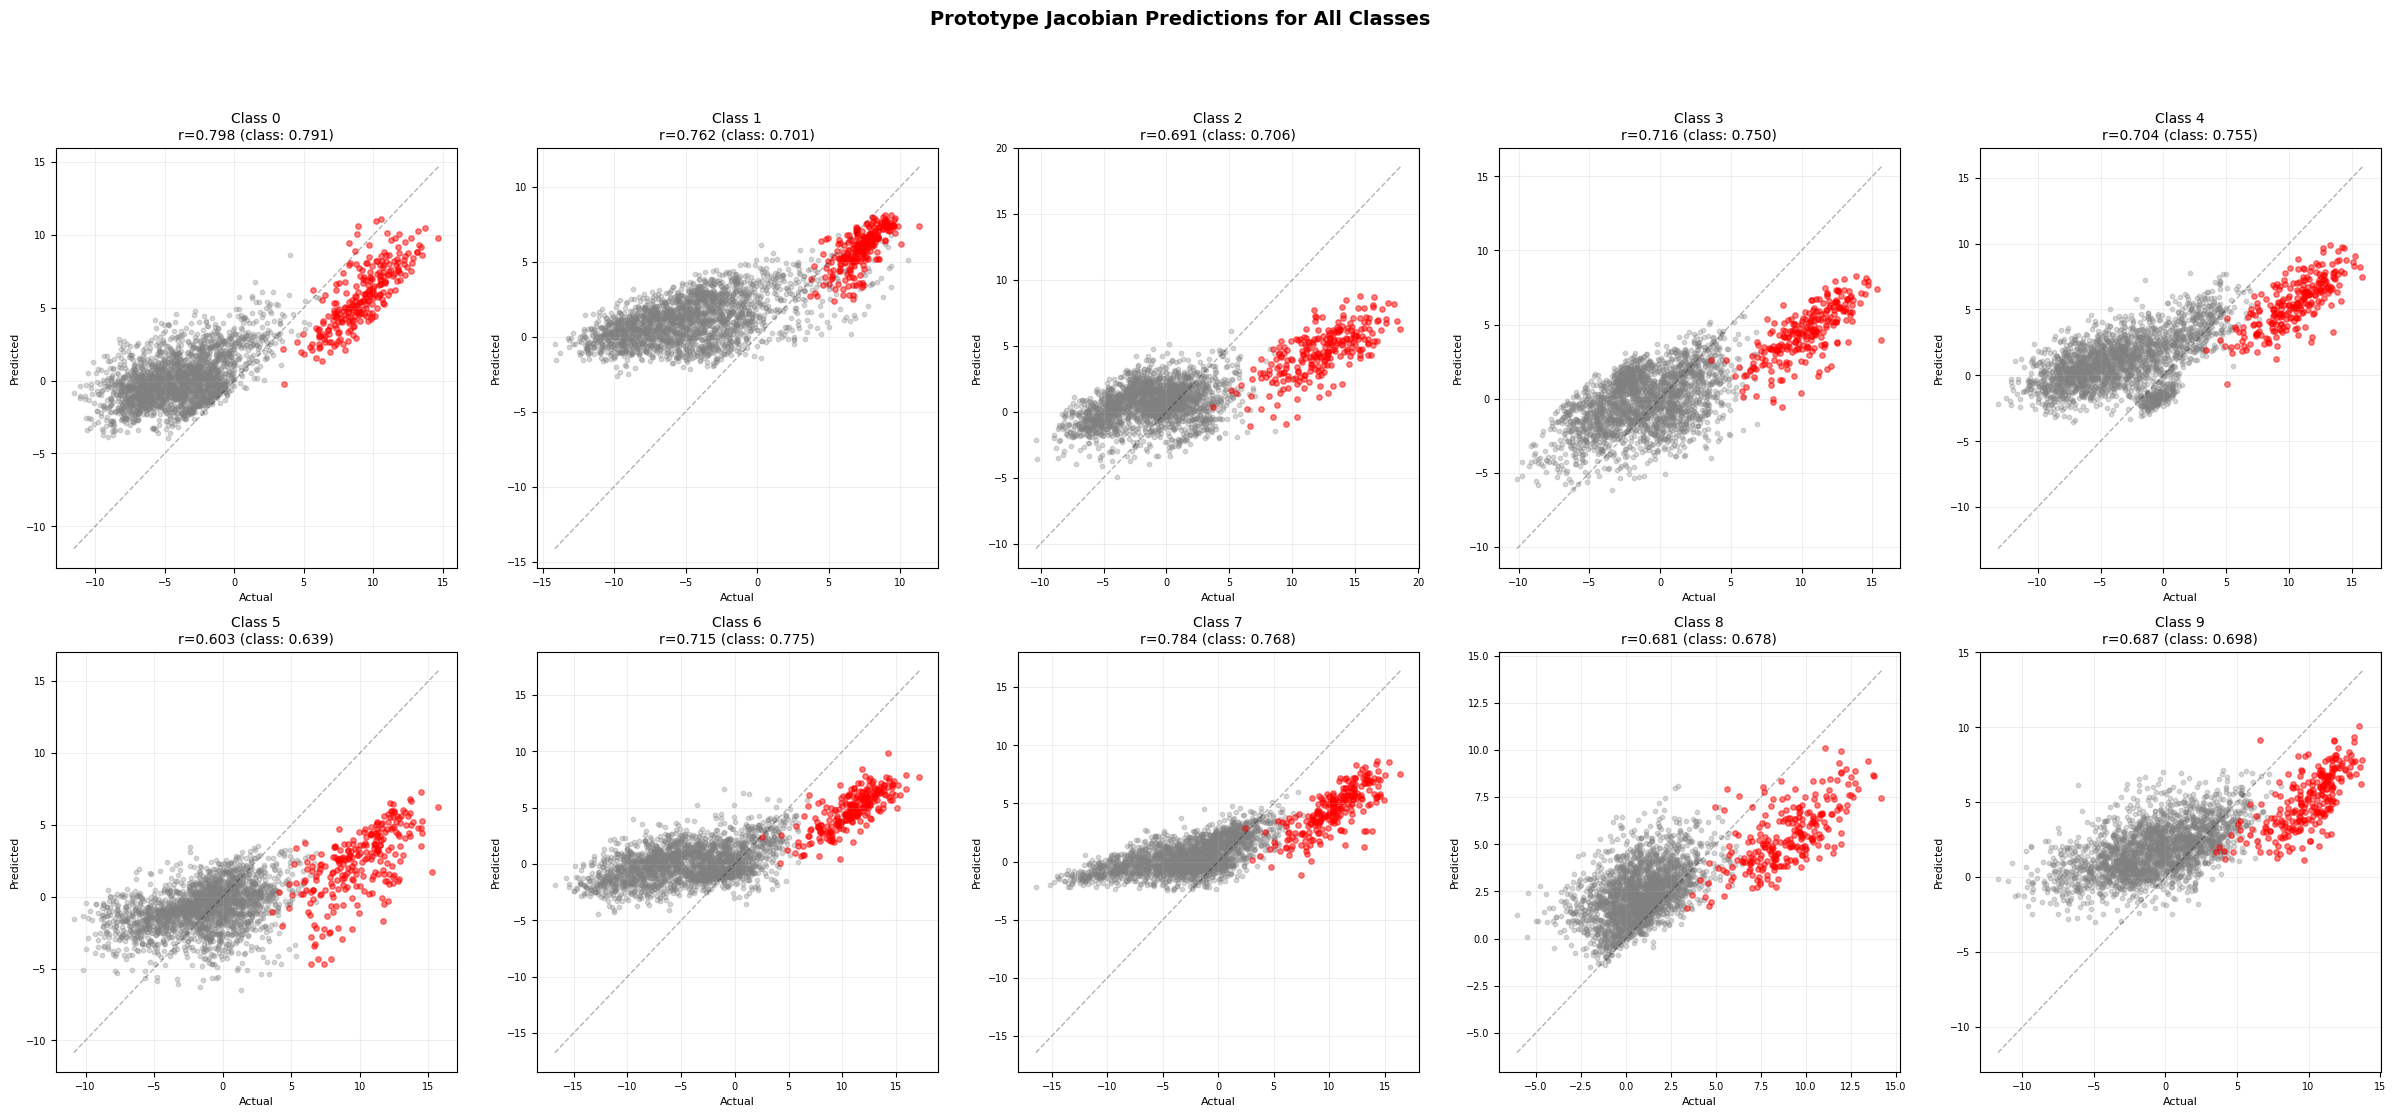


Classes ranked by within-class correlation:
----------------------------------------
 1. Class 0: r = 0.791
 2. Class 6: r = 0.775
 3. Class 7: r = 0.768
 4. Class 4: r = 0.755
 5. Class 3: r = 0.750
 6. Class 2: r = 0.706
 7. Class 1: r = 0.701
 8. Class 9: r = 0.698
 9. Class 8: r = 0.678
10. Class 5: r = 0.639


In [26]:
def analyze_all_prototype_classes(model, test_dataset, mean_jacs_split, test_idx, device='cpu'):
    """
    Run prototype Jacobian prediction analysis for all 10 classes

    Returns:
        results: dict with correlations and data for each class
    """
    results = {}

    print("Analyzing all 10 prototype classes...")

    for prototype_class in range(10):
        print(f"\nTesting prototype class {prototype_class}...")

        mean_jac_prototype = mean_jacs_split[prototype_class]

        pred_logits, actual_logits, labels, is_proto = test_prototype_jacobian_prediction_held_out(
            model, test_dataset, prototype_class, mean_jac_prototype, test_idx, device=device
        )

        # Compute correlations
        correlation_overall = np.corrcoef(pred_logits, actual_logits)[0, 1]

        pred_proto = pred_logits[is_proto]
        actual_proto = actual_logits[is_proto]
        pred_other = pred_logits[~is_proto]
        actual_other = actual_logits[~is_proto]

        corr_proto = np.corrcoef(pred_proto, actual_proto)[0, 1] if len(pred_proto) > 1 else 0
        corr_other = np.corrcoef(pred_other, actual_other)[0, 1] if len(pred_other) > 1 else 0

        results[prototype_class] = {
            'pred_logits': pred_logits,
            'actual_logits': actual_logits,
            'is_proto': is_proto,
            'corr_overall': correlation_overall,
            'corr_proto': corr_proto,
            'corr_other': corr_other,
            'n_proto': len(pred_proto),
            'n_other': len(pred_other)
        }
    return results

def visualize_all_prototype_predictions(results):
    """
    Create 2x5 grid of scatter plots for all prototype classes
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 12))

    for prototype_class in range(10):
        row = prototype_class // 5
        col = prototype_class % 5
        ax = axes[row, col]

        data = results[prototype_class]
        pred_logits = data['pred_logits']
        actual_logits = data['actual_logits']
        is_proto = data['is_proto']

        # Plot other classes
        ax.scatter(actual_logits[~is_proto], pred_logits[~is_proto],
                  alpha=0.3, s=10, c='gray', rasterized=True)

        # Plot prototype class
        ax.scatter(actual_logits[is_proto], pred_logits[is_proto],
                  alpha=0.5, s=15, c='red', rasterized=True)

        # Diagonal line
        min_val = min(actual_logits.min(), pred_logits.min())
        max_val = max(actual_logits.max(), pred_logits.max())
        ax.plot([min_val, max_val], [min_val, max_val],
               'k--', alpha=0.3, linewidth=1)

        # Labels and title
        ax.set_title(f'Class {prototype_class}\n'
                    f'r={data["corr_overall"]:.3f} '
                    f'(class: {data["corr_proto"]:.3f})',
                    fontsize=10)
        ax.set_xlabel('Actual', fontsize=8)
        ax.set_ylabel('Predicted', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.2)

    plt.suptitle('Prototype Jacobian Predictions for All Classes',
                fontsize=14, weight='bold', y=0.995)
    plt.show()


    # Print ranking
    print("\nClasses ranked by within-class correlation:")
    print("-" * 40)
    ranked = sorted([(i, results[i]['corr_proto']) for i in range(10)],
                   key=lambda x: x[1], reverse=True)
    for rank, (class_idx, corr) in enumerate(ranked, 1):
        print(f"{rank:2d}. Class {class_idx}: r = {corr:.3f}")

# Run the full analysis
results = analyze_all_prototype_classes(model, test_dataset, mean_jacs_split, test_idx, device=device)

# Visualize
visualize_all_prototype_predictions(results)

Computing EDJMs for all classes...
Computing EDJM for class 0...
Computing SVD for class 0...
  Spectral score: 10.20

Computing EDJM for class 1...
Computing SVD for class 1...
  Spectral score: 13.31

Computing EDJM for class 2...
Computing SVD for class 2...
  Spectral score: 11.63

Computing EDJM for class 3...
Computing SVD for class 3...
  Spectral score: 11.43

Computing EDJM for class 4...
Computing SVD for class 4...
  Spectral score: 11.72

Computing EDJM for class 5...
Computing SVD for class 5...
  Spectral score: 12.51

Computing EDJM for class 6...
Computing SVD for class 6...
  Spectral score: 12.06

Computing EDJM for class 7...
Computing SVD for class 7...
  Spectral score: 11.73

Computing EDJM for class 8...
Computing SVD for class 8...
  Spectral score: 11.69

Computing EDJM for class 9...
Computing SVD for class 9...
  Spectral score: 13.37



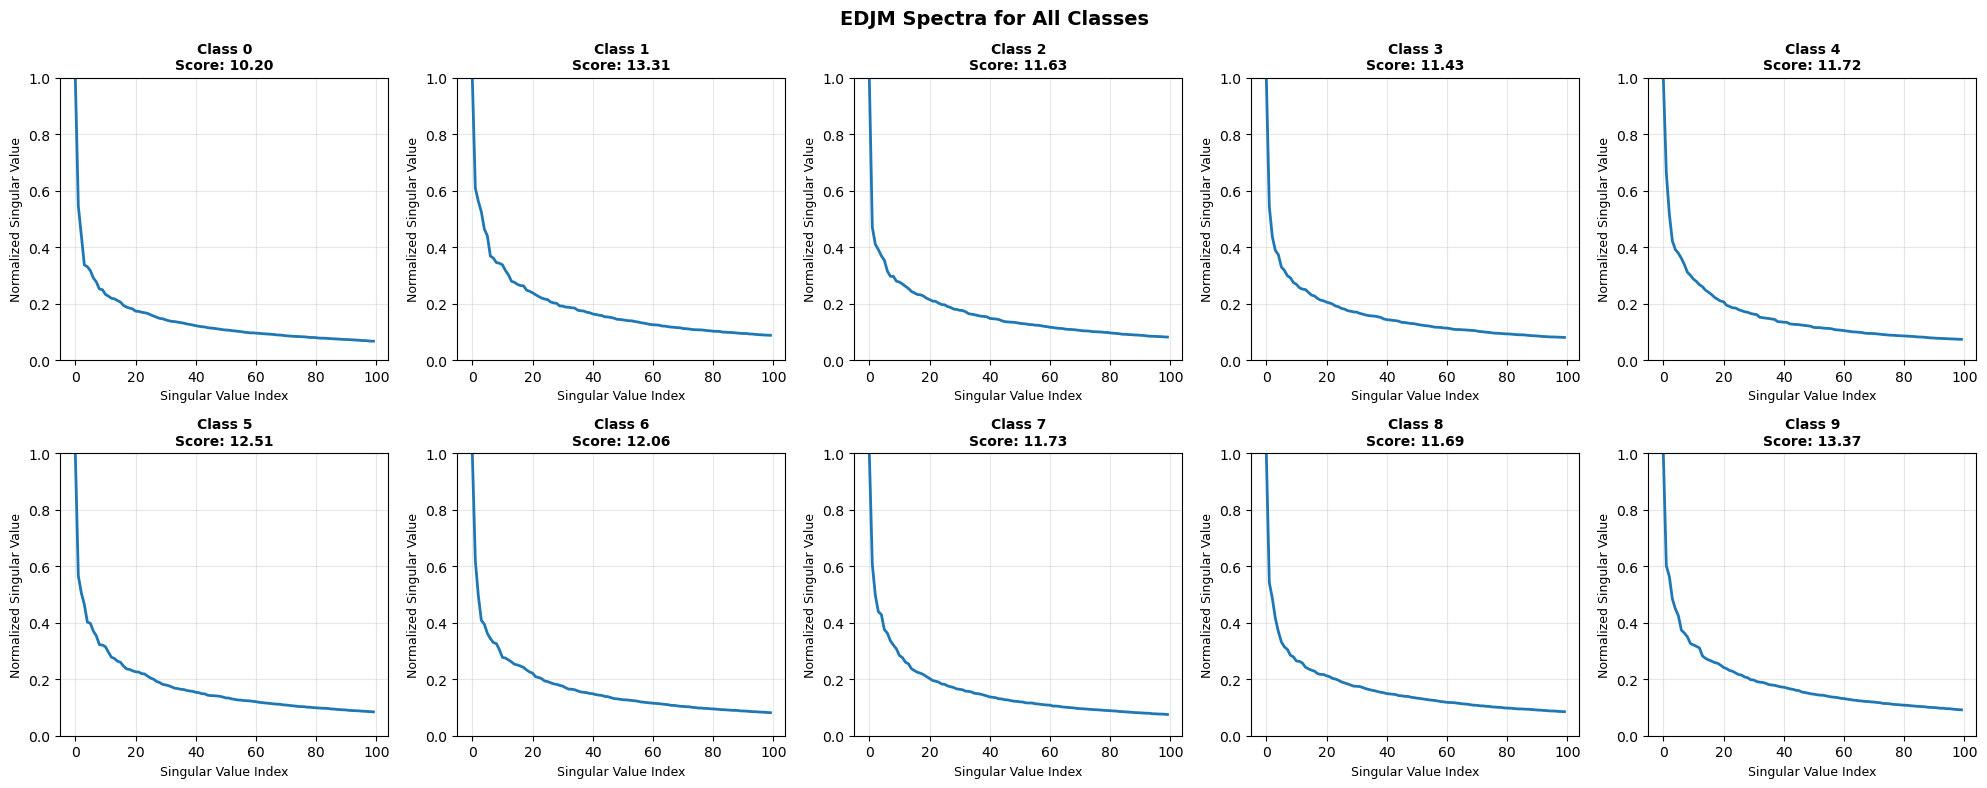

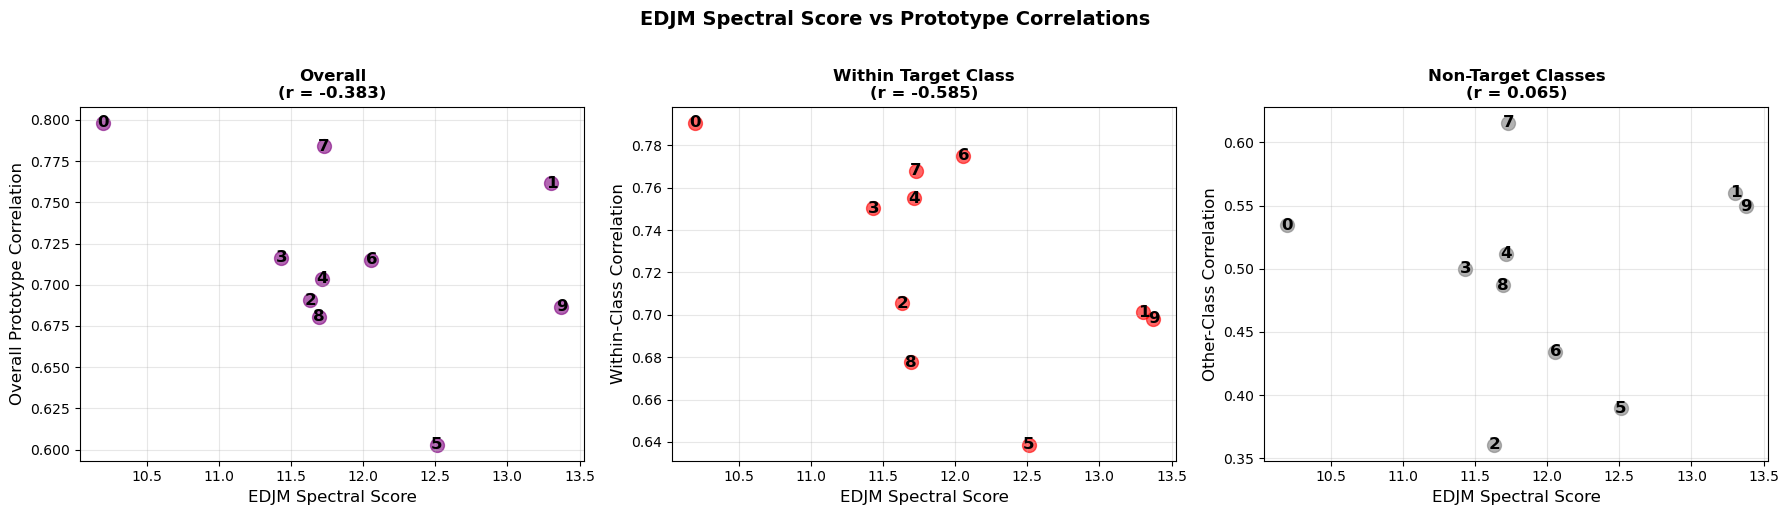


Comparison: EDJM Spectral Score vs Prototype Correlations
Class    Spectral     Overall      Within-Class   Other-Class   
         Score        Corr         Corr           Corr          
--------------------------------------------------------------------------------
0        10.20        0.798        0.791          0.534         
1        13.31        0.762        0.701          0.560         
2        11.63        0.691        0.706          0.361         
3        11.43        0.716        0.750          0.500         
4        11.72        0.704        0.755          0.512         
5        12.51        0.603        0.639          0.390         
6        12.06        0.715        0.775          0.434         
7        11.73        0.784        0.768          0.615         
8        11.69        0.681        0.678          0.487         
9        13.37        0.687        0.698          0.549         

Correlations with spectral score:
  Overall:      r = -0.383
  Within-class: r 

In [29]:
def compute_class_specific_edjm(model, test_dataset, target_class, n_samples=500, device='cpu'):
    """
    Compute EDJM for a specific class using ALL samples (not just that class)

    Each row is the Jacobian of that sample w.r.t. target_class logit

    Returns:
        edjm: (n_samples, 784) matrix of Jacobians
        labels: (n_samples,) true labels
    """
    model.eval()

    jacobians = []
    labels = []

    print(f"Computing EDJM for class {target_class}...")

    for i in range(min(n_samples, len(test_dataset))):
        image, label = test_dataset[i]
        image = image.to(device)

        # Compute Jacobian w.r.t. target_class output
        image_copy = image.clone().detach()
        image_copy.requires_grad = True

        output = model(image_copy.unsqueeze(0))
        model.zero_grad()
        output[0, target_class].backward()

        jac = image_copy.grad.squeeze().cpu().numpy().flatten()  # (784,)

        jacobians.append(jac)
        labels.append(label)

        if (i + 1) % 2000 == 0:
            print(f"  Processed {i+1}/{n_samples}")

    edjm = np.array(jacobians)  # (n_samples, 784)
    labels = np.array(labels)

    return edjm, labels

def compute_edjm_spectrum_score(singular_values, percentile=90):
    """
    Compute EDJM spectral score (sum of normalized top singular values)
    Similar to the score used in the EDJM paper
    """
    # Normalize by max
    normalized_sv = singular_values / singular_values[0]

    # Keep top percentile
    threshold = np.percentile(singular_values, percentile)
    significant_sv = normalized_sv[singular_values > threshold]

    score = np.sum(significant_sv)
    return score

def analyze_all_class_edjms(model, test_dataset, n_samples=500, device='cpu'):
    """
    Compute EDJM spectra for all 10 classes
    """
    all_edjms = {}
    all_spectra = {}
    all_scores = {}

    print("Computing EDJMs for all classes...")
    print("="*60)

    for target_class in range(10):
        edjm, labels = compute_class_specific_edjm(
            model, test_dataset, target_class, n_samples=n_samples, device=device
        )

        # Compute SVD
        print(f"Computing SVD for class {target_class}...")
        U, S, Vt = np.linalg.svd(edjm, full_matrices=False)

        # Compute score
        score = compute_edjm_spectrum_score(S)

        all_edjms[target_class] = edjm
        all_spectra[target_class] = S
        all_scores[target_class] = score

        print(f"  Spectral score: {score:.2f}\n")

    print("="*60)
    return all_edjms, all_spectra, all_scores

def visualize_edjm_spectra(all_spectra, all_scores):
    """
    Visualize EDJM spectra for all classes
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    # Find global max for consistent y-axis
    max_sv = max(spectra[0] for spectra in all_spectra.values())

    for class_idx in range(10):
        row = class_idx // 5
        col = class_idx % 5
        ax = axes[row, col]

        spectrum = all_spectra[class_idx]
        score = all_scores[class_idx]

        # Normalize and plot
        normalized_spectrum = spectrum / spectrum[0]

        ax.plot(normalized_spectrum[:100], linewidth=2)  # Plot first 100 components
        ax.set_xlabel('Singular Value Index', fontsize=9)
        ax.set_ylabel('Normalized Singular Value', fontsize=9)
        ax.set_title(f'Class {class_idx}\nScore: {score:.2f}', fontsize=10, weight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

    plt.suptitle('EDJM Spectra for All Classes', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

def compare_spectra_and_correlations(all_scores, prototype_results):
    """
    Compare EDJM spectral scores with different correlation types
    """
    classes = list(range(10))
    spectral_scores = [all_scores[i] for i in classes]
    corr_overall = [prototype_results[i]['corr_overall'] for i in classes]
    corr_proto = [prototype_results[i]['corr_proto'] for i in classes]
    corr_other = [prototype_results[i]['corr_other'] for i in classes]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Overall correlation
    ax1 = axes[0]
    ax1.scatter(spectral_scores, corr_overall, s=100, alpha=0.6, color='purple')
    for i in range(10):
        ax1.annotate(str(i), (spectral_scores[i], corr_overall[i]),
                    fontsize=12, ha='center', va='center', weight='bold')

    corr1 = np.corrcoef(spectral_scores, corr_overall)[0, 1]
    ax1.set_xlabel('EDJM Spectral Score', fontsize=12)
    ax1.set_ylabel('Overall Prototype Correlation', fontsize=12)
    ax1.set_title(f'Overall\n(r = {corr1:.3f})', fontsize=12, weight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Within-class correlation
    ax2 = axes[1]
    ax2.scatter(spectral_scores, corr_proto, s=100, alpha=0.6, color='red')
    for i in range(10):
        ax2.annotate(str(i), (spectral_scores[i], corr_proto[i]),
                    fontsize=12, ha='center', va='center', weight='bold')

    corr2 = np.corrcoef(spectral_scores, corr_proto)[0, 1]
    ax2.set_xlabel('EDJM Spectral Score', fontsize=12)
    ax2.set_ylabel('Within-Class Correlation', fontsize=12)
    ax2.set_title(f'Within Target Class\n(r = {corr2:.3f})', fontsize=12, weight='bold')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Other-class correlation
    ax3 = axes[2]
    ax3.scatter(spectral_scores, corr_other, s=100, alpha=0.6, color='gray')
    for i in range(10):
        ax3.annotate(str(i), (spectral_scores[i], corr_other[i]),
                    fontsize=12, ha='center', va='center', weight='bold')

    corr3 = np.corrcoef(spectral_scores, corr_other)[0, 1]
    ax3.set_xlabel('EDJM Spectral Score', fontsize=12)
    ax3.set_ylabel('Other-Class Correlation', fontsize=12)
    ax3.set_title(f'Non-Target Classes\n(r = {corr3:.3f})', fontsize=12, weight='bold')
    ax3.grid(True, alpha=0.3)

    plt.suptitle('EDJM Spectral Score vs Prototype Correlations',
                fontsize=14, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Print comparison table
    print("\nComparison: EDJM Spectral Score vs Prototype Correlations")
    print("="*80)
    print(f"{'Class':<8} {'Spectral':<12} {'Overall':<12} {'Within-Class':<14} {'Other-Class':<14}")
    print(f"{'':8} {'Score':<12} {'Corr':<12} {'Corr':<14} {'Corr':<14}")
    print("-"*80)

    for i in range(10):
        score = spectral_scores[i]
        c_overall = corr_overall[i]
        c_proto = corr_proto[i]
        c_other = corr_other[i]

        print(f"{i:<8} {score:<12.2f} {c_overall:<12.3f} {c_proto:<14.3f} {c_other:<14.3f}")

    print("="*80)
    print(f"\nCorrelations with spectral score:")
    print(f"  Overall:      r = {corr1:.3f}")
    print(f"  Within-class: r = {corr2:.3f}")
    print(f"  Other-class:  r = {corr3:.3f}")
    print("\nExpected: Negative correlation with within-class")
    print("          (high spectral score = complex = low within-class correlation)")


# Run the full analysis
all_edjms, all_spectra, all_scores = analyze_all_class_edjms(
    model, test_dataset, n_samples=500, device=device
)

# Visualize spectra
visualize_edjm_spectra(all_spectra, all_scores)

# Compare with prototype correlations (assuming you have 'results' from earlier)
compare_spectra_and_correlations(all_scores, results)